# Optimisation de réseaux de neurones profonds
Dans ce TP, on a une fonction $f:\mathbb R^2 \rightarrow \mathbb R$ qui n'est connue que sur un certain nombre de points $n$ (ici $n=200*200$). L'objectif est d'approximer cette fonction $f$ en dehors des points qui sont connus par un réseau de neurones profond du type MLP.

In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Présentation des données
Ici $f$ est une fonction de $[-1,1]\times [-1,1]$ dans $\mathbb{R}$ donnée par 
$x\mapsto \sin(6\pi |x|^{3/2})*|\sin(\pi*|y|) +x^2+y^2$. Elle est échantillonnée sur $nx=200$ points en $x$ et en $ny=y$. On connaît donc $n=nx*ny$ valeurs de la fonction. Les données d'entrées sont notées `inp` et est un tableau de taille $(2,n)$ et les données de sortie sont les valeurs de $f$, elles sont notées `outp` et est un tableau de taille $n$.

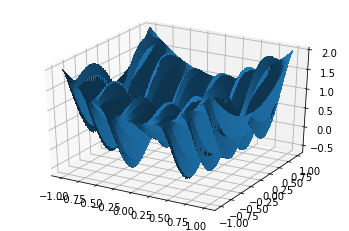

In [77]:
nx = 100
ny= 100
n=nx*ny
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,ny)
x, y = np.meshgrid(x, y)
z = np.sin(6*np.pi*np.abs(x)**1.5)*np.abs(np.sin(np.pi*np.abs(y))) + np.abs(x)**2+np.abs(y)**2
inp=np.zeros((2,n))
inp[0,:]=x.ravel()
inp[1,:]=y.ravel()
outp=z.ravel()

plt.clf
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, outp.reshape((nx,ny)),linewidth=0, antialiased=False)
plt.show()


# Réseau de neurone profond
Un réseau de neurone profond est une série de transformation du tableau `inp` de taille $(p,n)$ avec $p=2$ en un tableau final `inp3` de taille $(r,n)$ avec $r=1$. Ces transformations dépendront de paramètres, notés `theta`, l'objectif sera de trouver les `theta` pour que le tableau `inp3` se rapproche le plus du tableau `outp`. La contrainte est que les transformations sont toutes les mêmes pour toutes les données. Ici on se donnera les transformations suivantes

On transforme `inp` en `inp1`, un tableau de taille $(q,n)$ avec une transformation affine. Selon la règle, pour tout `i` :

 `inp1[:,i] =A.dot(inp[:,i]) +b`

Les coefficients de `A` et `b` sont des paramètres de `theta`.

On transforme `inp1` en `inp2`, un tableau de taille $(q,n)$ avec une transformation `sigmoide`. Selon la règle, que coefficient par coefficient :

`inp2= 1/(1+np.exp(-inp1))`

il n'y a pas de paramètres dans cette transformation

On transforme `inp2` en `inp3`, un tableau de taille $(r,n)$ avec une transformation affine, selon la règle, pour tout `i`

`inp3[i]=C.dot(inp2[:,i])+d`

Les coefficients de `C` et `d` sont des paramètres de `theta`.

Puis finalement on calcule `inp4` qui est un réel et qui vaut `inp4=norm(inp3-outp)**2`. Ainsi `inp4` sera la qualité d'approximation de notre réseau de neurone.

On note les variables `state=(inp1,inp2,inp3,inp4)` l'état de notre réseau de neurone, il dépend de `theta`, on veut minimiser `inp4` par rapport à `theta` et l'approximation de notre réseau est en fait la variable `inp3`.



On peut vérifier que `theta` est un grand vecteur de taille $(p+1+r)q+r$ ($pq$ pour `A`, $q$ pour `b`, $qr$ pour `C`, $r$ pour `d`). Dans un premier temps, il vous est donné une fonction qui calcule les matrices  `theta` si les matrices `(A,b,C,d)` sont données, c'est la fonction `get_theta(matrices)`. Implémentez la fonction `get_matrices(theta)` qui donne  `(A,b,C,d)` si le vecteur `theta` est donné . Et vérifiez le avec le code suivant :

In [64]:
p=2
q=20
r=1
import Neural
N=Neural.MLP(inp,outp,p=2,q=20,r=1)

np.random.seed(42)
theta=np.random.randn(N.nb_params)
matrices=N.get_matrices(theta)
print ('shapes',[m.shape for m in matrices])
print('norms',[np.linalg.norm(m.ravel()) for m in matrices])
theta2=N.get_theta(matrices)
print('0?=?',np.linalg.norm(theta2-theta))
# Vous devez trouver
#shapes [(20, 2), (20, 1), (1, 20), (1, 1)]
#norms [6.108848984955763, 3.5799825880241123, 4.849510401658014, 0.21967188783751193]
#0?=? 0.0

shapes [(20, 2), (20, 1), (1, 20), (1, 1)]
norms [6.108848984955763, 3.5799825880241123, 4.849510401658014, 0.21967188783751193]
0?=? 0.0


On vous donne dans le code python la fonction `product(A,b,x)` qui calcule `inp1` si `A` et `b` sont données et `x=inp`.. Implémentez une fonction `forward(theta)` qui prend le vecteur `theta` en paramètres, qui construit les matrices `(A,b,C,d)` et qui vous rend l'état `state=(inp1,inp2,inp3,inp4)`.


In [78]:
np.random.seed(42)
theta=np.random.randn(N.nb_params)
state=N.forward(theta)
print([s.shape for s in state])
print([np.linalg.norm(s.ravel()) for s in state])
# Vous devez trouver
# [(20, 10000), (20, 10000), (1, 10000), ()]
#[505.0437658534759, 243.9671602255805, 133.09224118724546, 22698.560640260617]


[(20, 10000), (20, 10000), (1, 10000), ()]
[505.0437658534759, 243.9671602255805, 133.09224118724546, 22698.560640260617]


# Rétropropagation du gradient
## Calcul direct de la différentielle
Nous allons supposer que `theta` est modifié en `theta +eps*dtheta` avec `dtheta` petit. Calculez mathématiquement la variation au premier ordre de `inp1,inp2,inp3,inp4`, selon la règle 

`inp1(theta+eps*dtheta)=inp1(theta)+eps*dinp1 +o(eps)`

on note cette variation `dstate=(dinp1,dinp2,dinp3,dinp4)`. Implémentez ce calcul dans un algorithme `diff(theta,state,dtheta)`. Cet algorithme vous rend `dstate=(dinp1,dinp2,dinp3,dinp4)`. Cet algorithme ressemble beaucoup à `forward`. Pour info la dérivée de la fonction sigmoide est donnée par
$$ x\mapsto \frac{e^{-x}}{(1+e^{-x})^2}$$

In [79]:
np.random.seed(42)
theta=np.random.randn(N.nb_params)
dtheta=np.random.randn(N.nb_params)
state=N.forward(theta)
dstate=N.diff(theta,state,dtheta)

print([ds.shape for ds in dstate])
print([np.linalg.norm(ds.ravel()) for ds in dstate])
# Vous devez trouver
#[(20, 10000), (20, 10000), (1, 10000), ()]
#[561.0515628565867, 106.30941062534491, 112.26289795568565, 8592.997396822391]



[(20, 10000), (20, 10000), (1, 10000), ()]
[561.0515628565867, 106.30941062534491, 112.26289795568565, 8592.997396822391]


On lance maintenant un test de dérivée numérique, pour vérifier tous nos calculs

In [80]:
### TEST DE DERIVEE NUMERIQUE
eps=1.e-8
state_num=N.forward(theta+eps*eta)
deriv_num=[(s_n-s).ravel() for (s_n,s) in zip(state_num,state)]
deriv_th=[(eps*s).ravel() for s in N.diff(theta,state,dtheta)]
ratio=[np.linalg.norm(d_n)/np.linalg.norm(d_t) for (d_n,d_t) in zip(deriv_num,deriv_th)]
angle=[np.dot(d_n,d_t)/(np.linalg.norm(d_n)*np.linalg.norm(d_t)) for (d_n,d_t) in zip(deriv_num,deriv_th) ]
print('ratio',ratio) # on doit trouver 1
print('angle',angle) # on doit trouver 1

ratio [0.9999999997217969, 0.999999999868595, 1.000000003632773, 0.9999999412310321]
angle [0.9999999999999996, 0.9999999999999989, 0.9999999999999992, 1.0]


## Rétropropagation
Nous sommes capables de calculer la différentielle, mais nous n'avons pas le gradient de `inp4` par rapport à `theta`. Pour calculer ce gradient, il faut trouver un vecteur `gtheta` tel que pour toute direction `dtheta`, on ait

`dinp4=(gtheta,dtheta)`

On rappelle que `theta` est composé des matrices `(A,b,C,d)`, que `dtheta` est composé des matrices `(dA,db,dC,dd)` et que si l'état du réseau est `state=(inp1,inp2,inp3,inp4)` alors les dérivées dans la direction `dtheta`
sont données par `dstate=(dinp1,dinp2,dinp3,dinp4)`. On va construire un état `gstate=(ginp1,ginp2,ginp3,ginp4)` et le vecteur correspondant `gtheta` composé des matrices `(gA,gb,gC,gd)`. Le `gstate` sert à se débarasser des variables `dstate` dans le calcul de `dinp4` et le vecteur `gtheta` sera le gradient. 
Pour cela il est primordial de  remarquer que le `dstate` est calculé dans un certain ordre et qu'il dépend linéairement de `dtheta` et de lui même (voir la fonction `N.diff()`). Le `gstate`  et le vecteur `gtheta` seront calculés dans l'ordre inverse du `dstate`, en utilisant la fonction `N.diff()` à l'envers  selon l'algorithme suivant :

Calcul de `ginp4` : En fait, il ne sert à rien ici, on va le mettre égal à `np.array([1.])`

Calcul de `ginp3`. On se débarasse de `dinp4` : comme `dinp4=(p,dinp3)` avec `p` un vecteur que vous avez calculé alors on construit `ginp3` tel que pour tout x, on ait `(ginp3,x)=(p,x)`, on obtient 

`dinp4 =(ginp3,dinp3)`

Calcul de `ginp2` : On se débarasse de `dinp3` : comme `dinp3=product(dC,dd,inp2) +C.dot(dinp2)`, on va construire `ginp2` tel que pour tout x on a `(ginp2,x)=(C.dot(x),ginp3)` et on construit `gC` et `gd` tels que pour tout `x` et `y` on a
`(ginp3,product(x,y,inp2))=(gC,x)+(gd,y)`
ainsi 

`dinp4=(ginp3,dinp3)=(gC,dC)+(gd,dd)+(ginp2,dinp2).`

Calcul de `ginp1` : On se débarasse de `dinp2` : comme `dinp2=m*dinp1` avec `m` un vecteur que vous avez trouvé. On calcule `ginp1` qui résout `(ginp1,x)=(ginp2,m*x)` pour tout `x` et on obtient

`dinp4=(gC,dC)+(gd,dd)+(ginp1,dinp1)`

On se débarasse de `dinp1` : Comme `dinp1=product(dA,db,inp)`, on construit `gA` et `gb` tels que pour tout `x` et `y`, on a
`(ginp1,product(x,y,inp))=(gA,x)+(gb,y)`
on obtient finalement

`dinp4=(gC,dC)+(gd,dd)+(gA,dA)+(gb,db)`

On a gagné : en construisant le vecteur `gtheta` qui vaut `(gA,gb,gC,gd)`, on a montré que
`dinp4=(gtheta,dtheta)`
Et on a bien le gradient de `inp4` par rapport à `theta` qui vaut `dtheta`.


In [71]:
np.random.seed(42)
theta=np.random.randn(N.nb_params)
dtheta=np.random.randn(N.nb_params)
state=N.forward(theta)
dstate=N.diff(theta,state,dtheta)
gstate,gtheta=N.backward(theta,state)

(dinp1,dinp2,dinp3,dinp4) = dstate
(ginp1,ginp2,ginp3,ginp4) = gstate
(gA,gb,gC,gd) = N.get_matrices(gtheta)

### VERIFICATION du BACKWARD
print('verification de ginp3 {} = {}'.format(dinp4,np.dot(dinp3.ravel(),ginp3.ravel())))
gtheta_tmp=N.get_theta((np.zeros_like(gA),np.zeros_like(gb),gC,gd))
tmp=np.dot(gtheta_tmp,dtheta)
tmp+=np.dot(dinp2.ravel(),ginp2.ravel())
print('verification de ginp2 {} = {}'.format(dinp4,tmp))
tmp=np.dot(gtheta_tmp,dtheta)
tmp+=np.dot(dinp1.ravel(),ginp1.ravel())
print('verification de ginp1 {} = {}'.format(dinp4,tmp))
print('VERIFICATION FINALE   {} = {}'.format(dinp4,np.dot(gtheta,dtheta)))


####################### VERIFICATIONS DES CALCULS (au besoin)
#print('state',[np.linalg.norm(u.ravel()) for u in state])
#print('dstate',[np.linalg.norm(u.ravel()) for u in dstate])
#print('gstate',[np.linalg.norm(u.ravel()) for u in gstate])
#print('theta',[np.linalg.norm(u.ravel()) for u in N.get_matrices(theta)])
#print('dtheta',[np.linalg.norm(u.ravel()) for u in N.get_matrices(dtheta)])
#print('gtheta',[np.linalg.norm(u.ravel()) for u in N.get_matrices(gtheta)])
# Vous devez trouver
#state [505.0437658534759, 243.9671602255805, 133.09224118724546, 22698.560640260617]
#dstate [561.0515628565867, 106.30941062534491, 112.26289795568565, 8592.997396822391]
#gstate [212.44717809233578, 1033.265793760996, 213.06600216956537, 1.0]
#theta [6.108848984955763, 3.5799825880241123, 4.849510401658014, 0.21967188783751193]
#dtheta [5.437522445351683, 4.628523898749744, 4.054752387371352, 0.787084603742452]
#gtheta [3549.503277093801, 19539.815055094423, 46732.88090202075, 20217.092817374953]

verification de ginp3 8592.997396822391 = 8592.997396822391
verification de ginp2 8592.997396822391 = 8592.99739682239
verification de ginp1 8592.997396822391 = 8592.99739682239
VERIFICATION FINALE   8592.997396822391 = 8592.99739682239


# Optimisation
Nous sommes maintenant en position de définir une fonction `N.eval(theta)` qui rend `inp4` après un calcul du `forward`. Nous allons aussi définir une fonction `N.grad(theta)` qui lance un `forward` pour calculer le `state` puis qui lance un `backward` et rend `gtheta`. 

In [73]:
np.random.seed(42)
theta=np.random.randn(N.nb_params)
print(N.eval(theta))
print(np.linalg.norm(N.grad(theta)))
# Vous devez trouver
#22698.560640260617
#54654.335100613964

22698.560640260617
54654.335100613964


Grâce aux fonctions `eval` et `grad`, on peut lancer sans soucis des algorithmes de gradient à pas fixe, comme par exemple dans l'exemple suivant :

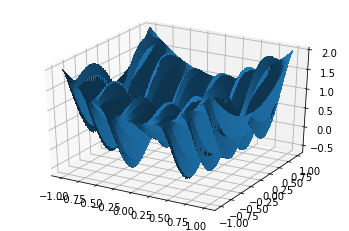

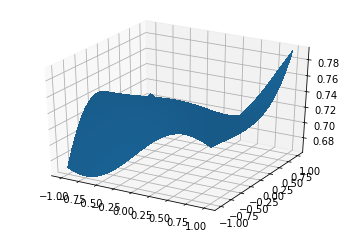

In [74]:
nbiter=400
step=3.e-6
cost=np.zeros((nbiter+1))
np.random.seed(42)
theta=np.random.randn(N.nb_params)
for k in range(nbiter) :
    cost[k]=N.eval(theta)
    theta-=step*N.grad(theta)
cost[nbiter]=N.eval(theta)
# On retrouve maintenant les prédictions du réseau de neurones, qui est la variable inp3 du state
(inp1,inp2,inp3,inp4)=N.forward(theta)

plt.clf
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, outp.reshape((nx,ny)),linewidth=0, antialiased=False)
plt.show()
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, inp3.reshape((nx,ny)),linewidth=0, antialiased=False)
plt.show()


On peut jouer avec les paramètres pour essayer de faire avancer le réseau plus vite, on peut essayer de lancer une accélération de Wolfe, etc... Ce qui marche le mieux est encore un BFGS comme ci-dessous :

         Current function value: 245.015415
         Iterations: 400
         Function evaluations: 440
         Gradient evaluations: 440


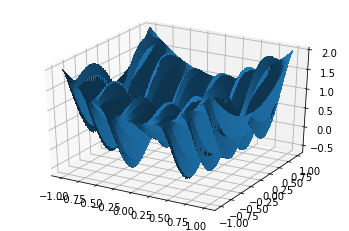

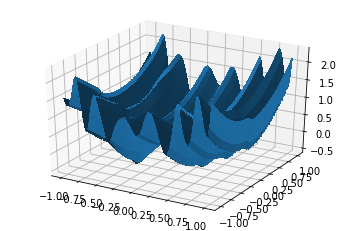

In [75]:
from scipy.optimize import minimize
np.random.seed(42)
theta=np.random.randn(N.nb_params)

res = minimize(N.eval, theta, method='BFGS', jac=N.grad, options={'gtol': 1e-6, 'disp': True, 'maxiter': 400});
theta = res.x
# On retrouve maintenant les prédictions du réseau de neurones, qui est la variable inp3 du state
(inp1,inp2,inp3,inp4)=N.forward(theta)

plt.clf
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, outp.reshape((nx,ny)),linewidth=0, antialiased=False)
plt.show()
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, inp3.reshape((nx,ny)),linewidth=0, antialiased=False)
plt.show()